In [19]:
import torch
from einops import rearrange

# Load the PyTorch model from the .pt file
model = torch.load('/users/ankushroy/iris/outputs/2023-10-06/16-05-27/media/episodes/train/episode_0_epoch_4.pt', map_location=torch.device('cpu'))
observations= model['observations']
observations= observations.unsqueeze(0)
# Print the model architecture or other relevant information
print(observations.size())

# observations=rearrange(observations, 't b h w -> b t h w ')
# shape= observations.shape
# print(shape[1])
# print(observations.shape)

torch.Size([1, 16, 64, 128, 128])


In [6]:
import time
import hydra
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
import matplotlib.pyplot as plt

In [7]:
import yaml

# Open and read the YAML file
with open('/users/ankushroy/iris/outputs/2023-10-06/16-05-27/config/trainer.yaml', 'r') as config_file:
    cfg = yaml.safe_load(config_file)
cfg.keys()

dict_keys(['wandb', 'initialization', 'common', 'collection', 'training', 'evaluation', 'tokenizer', 'world_model', 'env', 'datasets'])

In [8]:
from models.tokenizer import Tokenizer
from utils import extract_state_dict
from hydra.utils import instantiate
from make_reconstructions import make_reconstructions_from_batch

In [9]:
tokenizer = instantiate(cfg['tokenizer'])

Tokenizer : shape of latent is (512, 4, 4).


In [10]:
agent_state_dict = torch.load('/space/ankushroy/last.pt', map_location=torch.device('cuda:0'))
print(extract_state_dict(agent_state_dict, 'tokenizer').keys())
tokenizer.load_state_dict(extract_state_dict(agent_state_dict, 'tokenizer'))

odict_keys(['encoder.conv_in.weight', 'encoder.conv_in.bias', 'encoder.down.0.block.0.norm1.weight', 'encoder.down.0.block.0.norm1.bias', 'encoder.down.0.block.0.conv1.weight', 'encoder.down.0.block.0.conv1.bias', 'encoder.down.0.block.0.norm2.weight', 'encoder.down.0.block.0.norm2.bias', 'encoder.down.0.block.0.conv2.weight', 'encoder.down.0.block.0.conv2.bias', 'encoder.down.0.block.1.norm1.weight', 'encoder.down.0.block.1.norm1.bias', 'encoder.down.0.block.1.conv1.weight', 'encoder.down.0.block.1.conv1.bias', 'encoder.down.0.block.1.norm2.weight', 'encoder.down.0.block.1.norm2.bias', 'encoder.down.0.block.1.conv2.weight', 'encoder.down.0.block.1.conv2.bias', 'encoder.down.0.downsample.conv.weight', 'encoder.down.0.downsample.conv.bias', 'encoder.down.1.block.0.norm1.weight', 'encoder.down.1.block.0.norm1.bias', 'encoder.down.1.block.0.conv1.weight', 'encoder.down.1.block.0.conv1.bias', 'encoder.down.1.block.0.norm2.weight', 'encoder.down.1.block.0.norm2.bias', 'encoder.down.1.block.

<All keys matched successfully>

In [11]:
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field


In [36]:
from einops import rearrange
import numpy as np
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field


@torch.no_grad()
def make_reconstructions_from_batch(batch, save_dir, epoch, tokenizer):
    #check_batch(batch)

    original_frames = rearrange(batch['observations'], 'c t b h w  -> (b t) c h w')
    batch_tokenizer = batch['observations']

    rec_frames = generate_reconstructions_with_tokenizer(batch_tokenizer, tokenizer)

    for i in range(5):
        original_frame = original_frames[i,0,:,:]
        a_display = tensor_to_np_frames(original_frame)
        rec_frame = rec_frames[i,0,:,:]
        ar_display = tensor_to_np_frames(rec_frame)

        # Plot the precipitation fields using your plot_precip_field function
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plot_precip_field(a_display, title="Input")
        
        plt.subplot(1, 2, 2)
        plot_precip_field(ar_display, title="Reconstruction")

        plt.savefig(os.path.join(save_dir, f'epoch_{epoch:03d}_t_{i:03d}.png'))

        # Optionally, display the figure if needed
        plt.show()

        # Close the figure to free up resources
        plt.close()


    return

def tensor_to_np_frames(inputs):
    #check_float_btw_0_1(inputs)
    return inputs.cpu().numpy()*40


# def check_float_btw_0_1(inputs):
    # assert inputs.is_floating_point() and (inputs >= 0).all() and (inputs <= 1).all()


@torch.no_grad()
def generate_reconstructions_with_tokenizer(batch, tokenizer):
    #check_batch(batch)
    inputs = rearrange(batch, 'c t b h w  -> (b t) c h w')      #[1, 16, 64, 128, 128]
    outputs = reconstruct_through_tokenizer(inputs, tokenizer)
    b, t, _, _, _ = batch.size()
    # outputs = rearrange(outputs, '(b t) c h w -> b t h w c', b=b, t=t)
    rec_frames = outputs
    return rec_frames


@torch.no_grad()
def reconstruct_through_tokenizer(inputs, tokenizer):
    #check_float_btw_0_1(inputs)
    reconstructions = tokenizer.encode_decode(inputs, should_preprocess=True, should_postprocess=True)
    return torch.clamp(reconstructions, 0, 1)


def compute_metrics (batch, rec_frames):
    #threshold = 0.0
    input_images = rearrange(batch, 'c t b h w  -> (b t) c h w')
    input_images = input_images.squeeze(1)                                  #  (bt) c h w -> (bt) h w
    #reconstruction = rearrange(rec_frames, 'c t b h w  -> (b t) c h w')
    reconstruction = rec_frames.squeeze(1)                                  #  (bt) c h w -> (bt) h w
    metrics_pysteps = []
    pcc_average = 0.0
    # input images and reconstruction/prediction images should be of the same shape to perform the below operation
    
    for i in range(input_images.shape[0]):   #input images of shape [128, 128] for pysteps evaluation
        if i >=5: break
        input_images_npy = tensor_to_np_frames(input_images[i])
        reconstruction_npy = tensor_to_np_frames(reconstruction[i])
        #ar_display[ar_display < threshold] = 0.0   
        
        scores_cat1 = det_cat_fct(reconstruction_npy, input_images_npy, 1)
        scores_cat2 = det_cat_fct(reconstruction_npy, input_images_npy, 2)
        scores_cat8 = det_cat_fct(reconstruction_npy, input_images_npy, 8)
        scores_cont = det_cont_fct(reconstruction_npy, input_images_npy, thr=0.1)
        
        scores_spatial = intensity_scale(reconstruction_npy, input_images_npy, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        
        metrics = {'MSE:': np.around(scores_cont['MSE'],3), 
                    'MAE:': np.around(scores_cont['MAE'],3), 
                    'PCC:': np.around(scores_cont['corr_p'],3), 
                    'CSI(1mm):': np.around(scores_cat1['CSI'],3),   # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):': np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):': np.around(scores_cat8['CSI'],3),
                    'ACC(1mm):': np.around(scores_cat1['ACC'],3),   # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):': np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):': np.around(scores_cat8['ACC'],3),
                    'FSS(1km):': np.around(scores_spatial[0][0],3),
                    'FSS(10km):': np.around(scores_spatial[1][0],3),
                    'FSS(20km):': np.around(scores_spatial[2][0],3),
                    'FSS(30km):': np.around(scores_spatial[3][0],3),
                    'pcc_average': pcc_average/i if i != 0 else 0,
        }
        metrics_pysteps.append(metrics)
        
    return metrics_pysteps 




In [25]:
observations= model['observations']
observations= observations.unsqueeze(0)
rec_frames = generate_reconstructions_with_tokenizer(observations, tokenizer)
metrics = compute_metrics(observations,rec_frames)


In [31]:
for i, metric in enumerate(metrics):
    print(f"Metric {i}:", metric, '\n')

Metric 0: {'MSE:': 1.226, 'MAE:': 0.646, 'PCC:': 0.481, 'CSI(1mm):': 0.386, 'CSI(2mm):': 0.222, 'CSI(8mm):': 0.026, 'ACC(1mm):': 0.856, 'ACC(2mm):': 0.922, 'ACC(8mm):': 0.995, 'FSS(1km):': 0.624, 'FSS(10km):': 0.611, 'FSS(20km):': 0.585, 'FSS(30km):': 0.524, 'pcc_average': 0} 

Metric 1: {'MSE:': 1.547, 'MAE:': 0.623, 'PCC:': 0.394, 'CSI(1mm):': 0.347, 'CSI(2mm):': 0.19, 'CSI(8mm):': 0.0, 'ACC(1mm):': 0.878, 'ACC(2mm):': 0.934, 'ACC(8mm):': 0.994, 'FSS(1km):': 0.559, 'FSS(10km):': 0.545, 'FSS(20km):': 0.524, 'FSS(30km):': 0.469, 'pcc_average': 0.875} 

Metric 2: {'MSE:': 1.399, 'MAE:': 0.589, 'PCC:': 0.379, 'CSI(1mm):': 0.327, 'CSI(2mm):': 0.206, 'CSI(8mm):': 0.012, 'ACC(1mm):': 0.888, 'ACC(2mm):': 0.941, 'ACC(8mm):': 0.995, 'FSS(1km):': 0.51, 'FSS(10km):': 0.5, 'FSS(20km):': 0.484, 'FSS(30km):': 0.435, 'pcc_average': 0.627} 

Metric 3: {'MSE:': 1.583, 'MAE:': 0.573, 'PCC:': 0.4, 'CSI(1mm):': 0.326, 'CSI(2mm):': 0.165, 'CSI(8mm):': 0.019, 'ACC(1mm):': 0.89, 'ACC(2mm):': 0.937, 'ACC(8mm

In [40]:
observations= model['observations']
#observations= observations.unsqueeze(0)
print(observations.shape)
make_reconstructions_from_batch(observations, save_dir='/space/ankushroy', epoch=4, tokenizer=tokenizer)

torch.Size([16, 64, 128, 128])


IndexError: too many indices for tensor of dimension 4

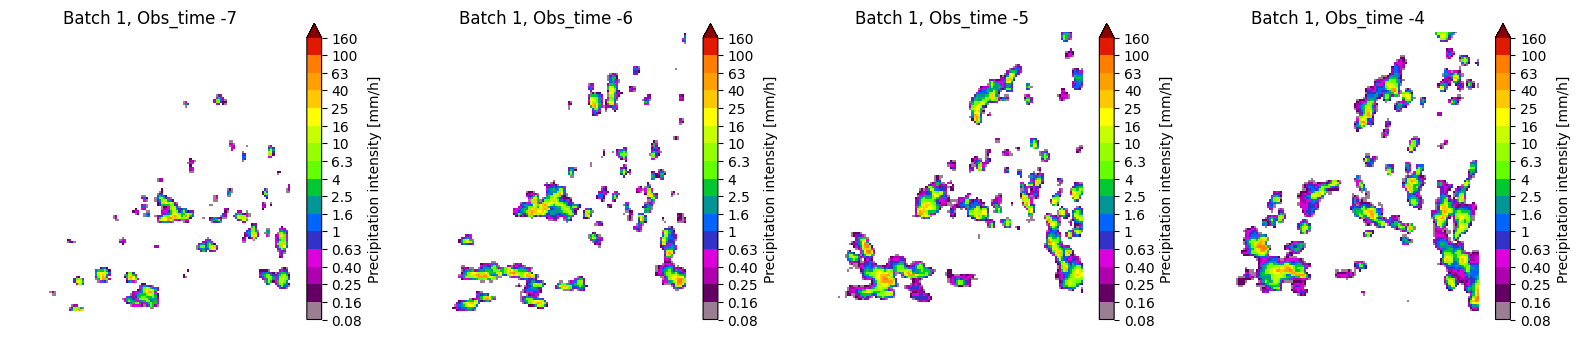

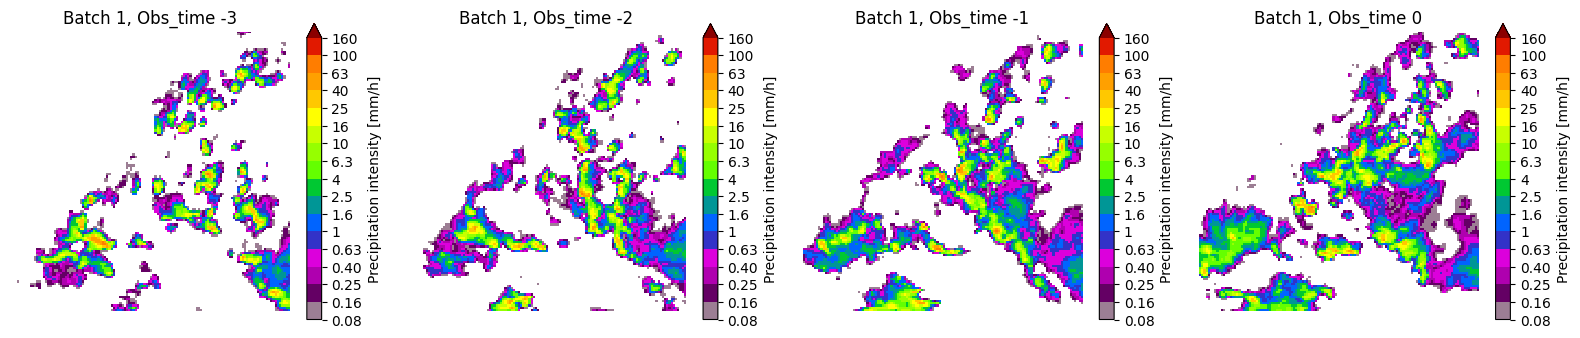

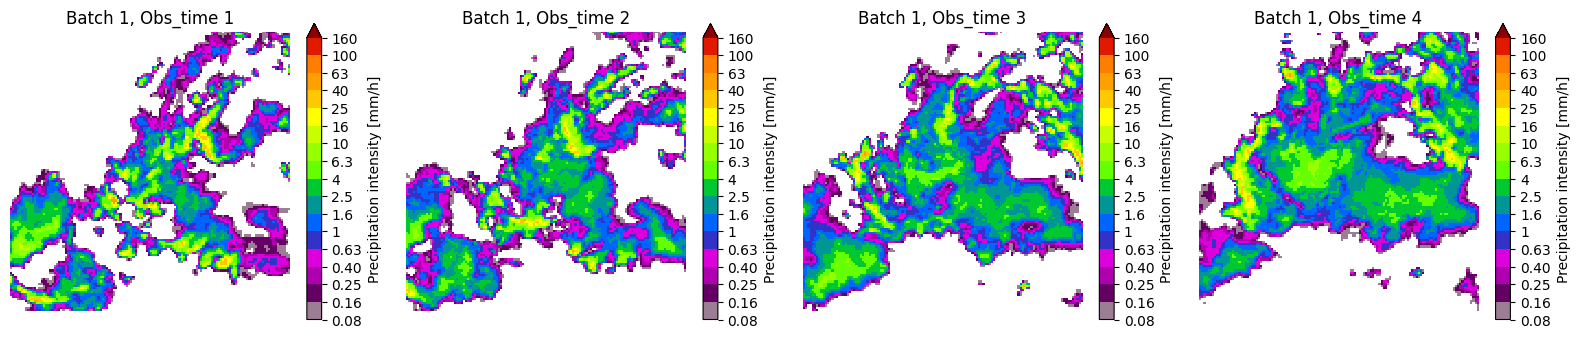

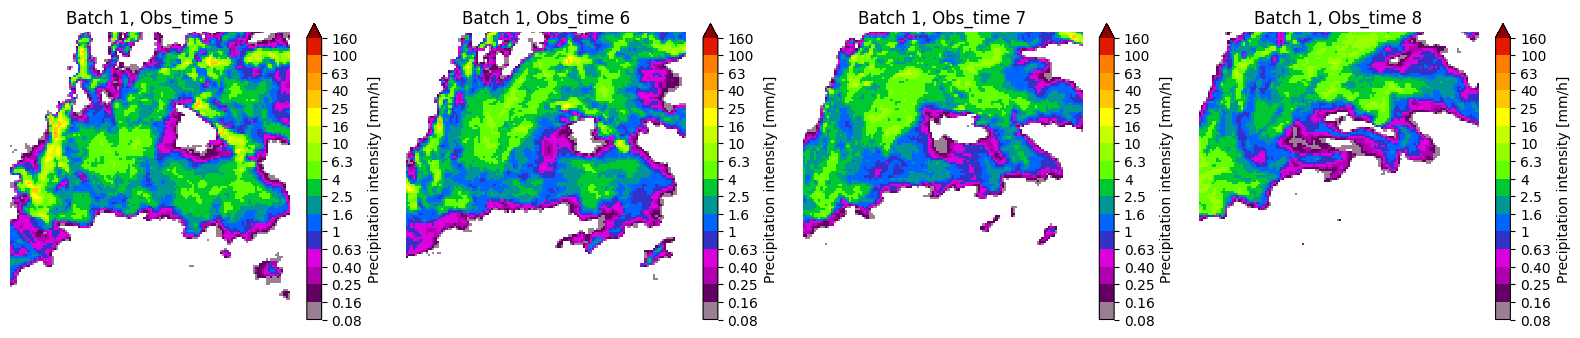

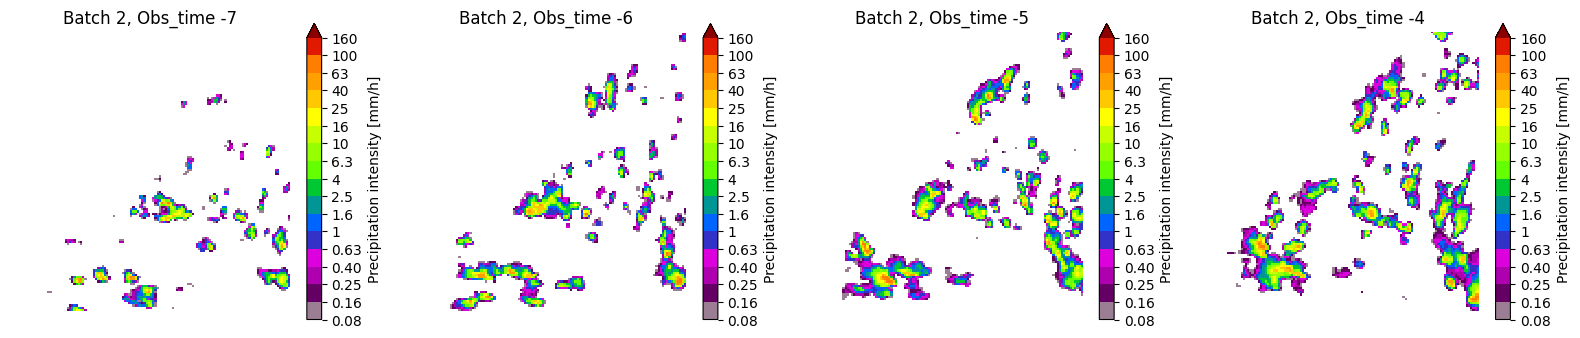

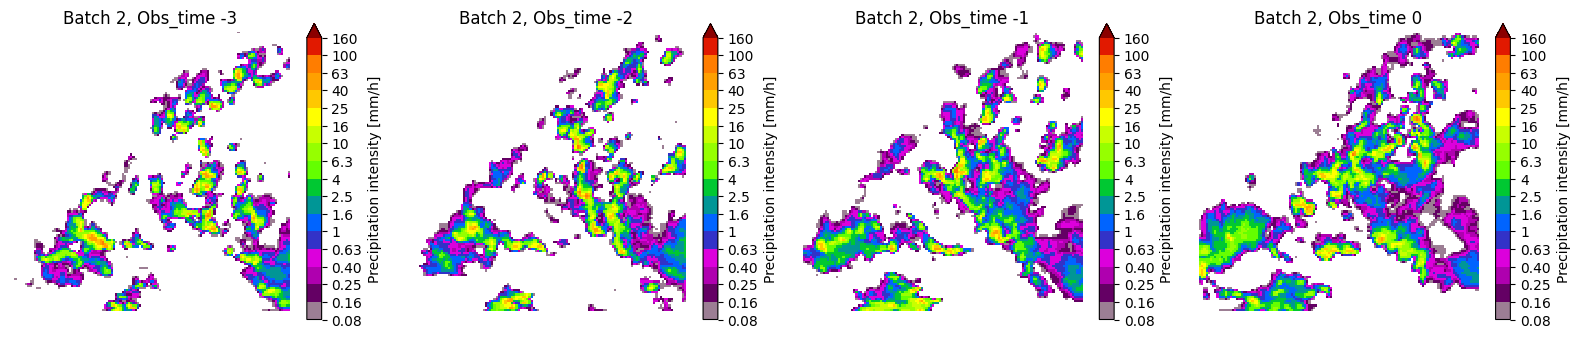

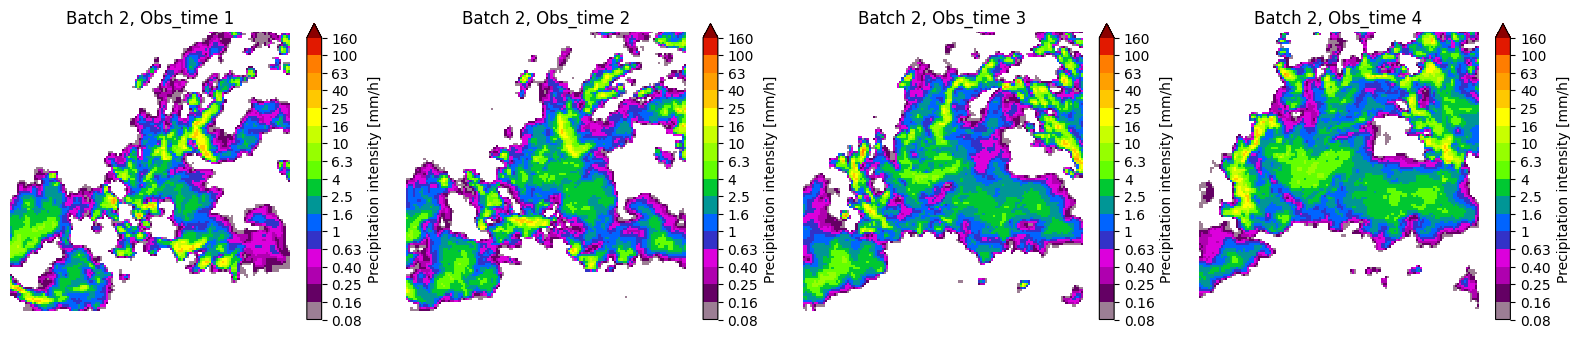

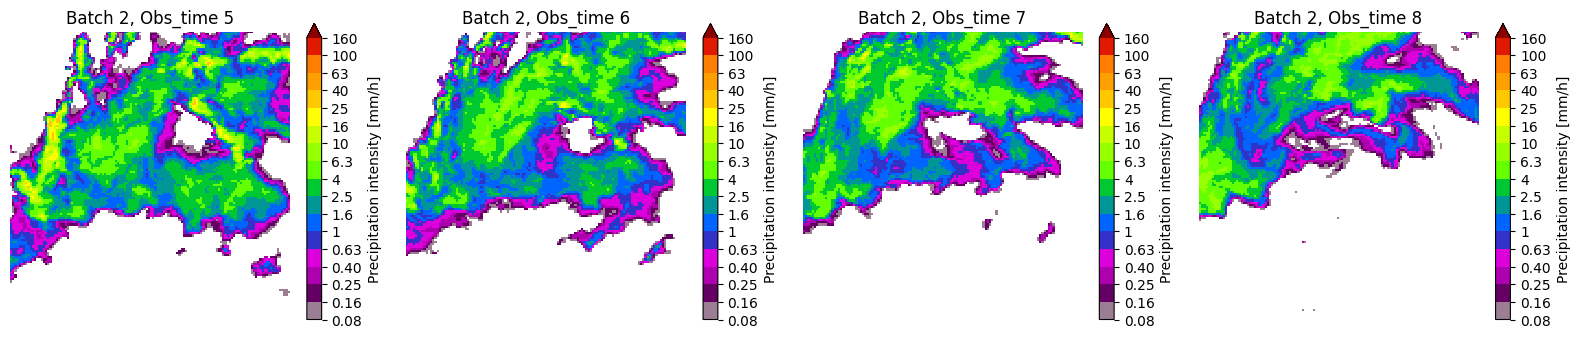

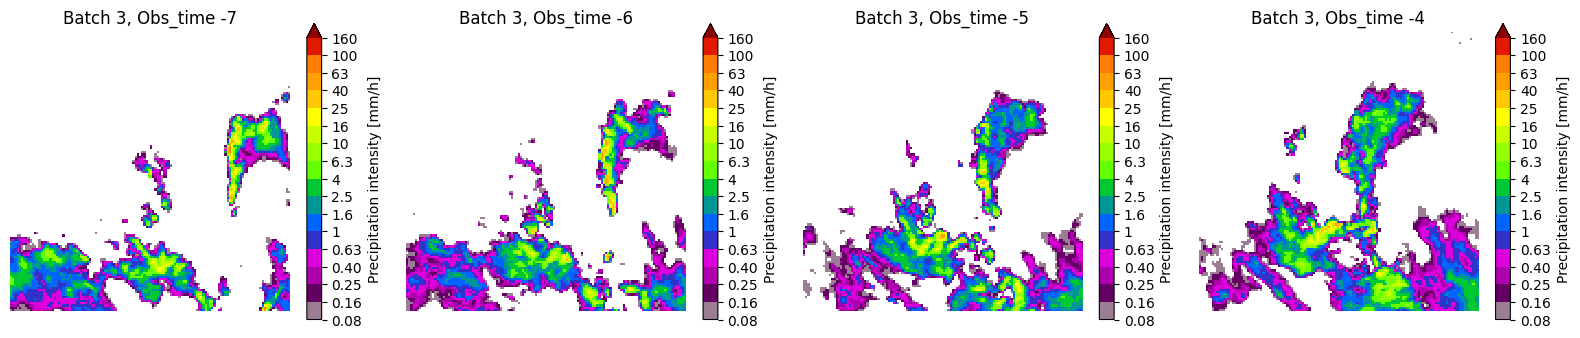

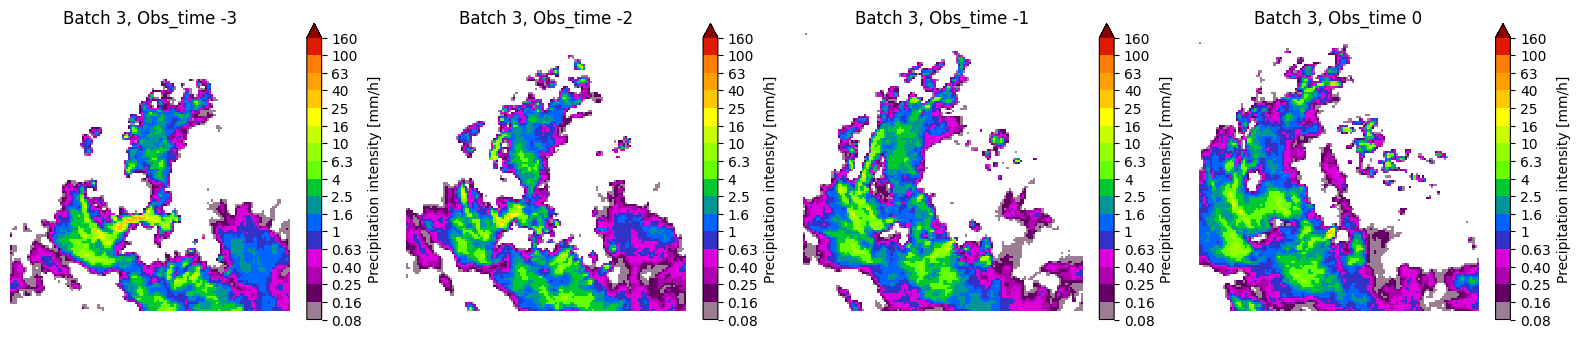

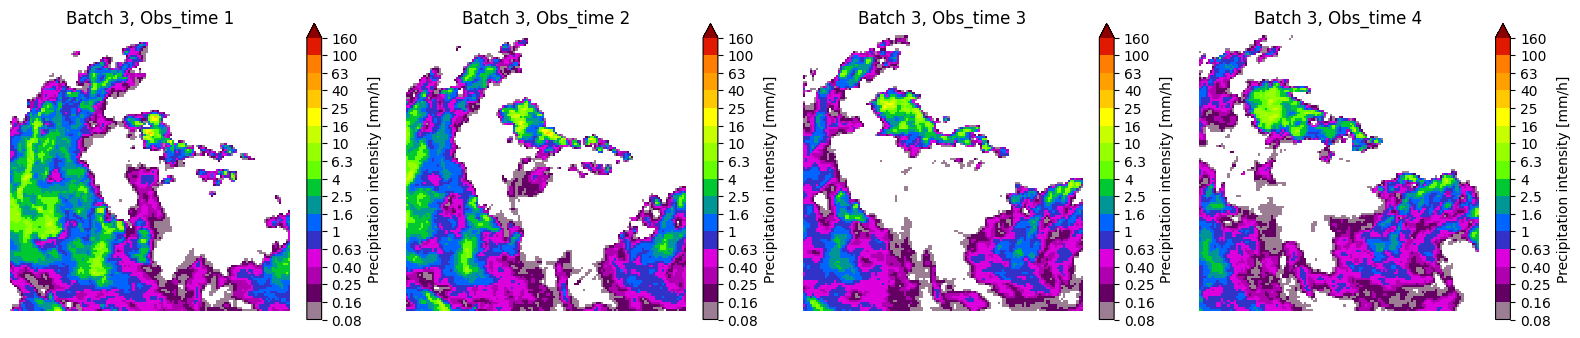

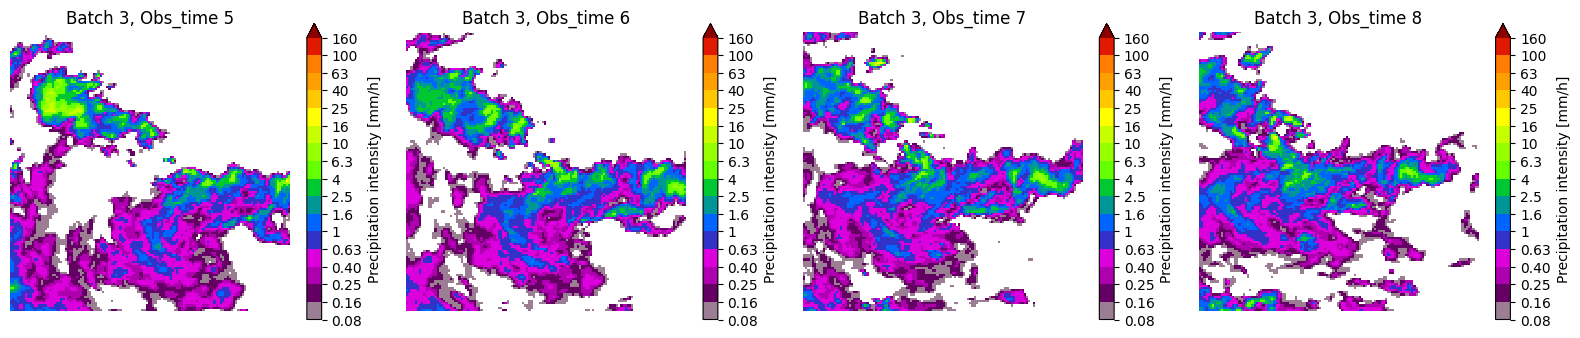

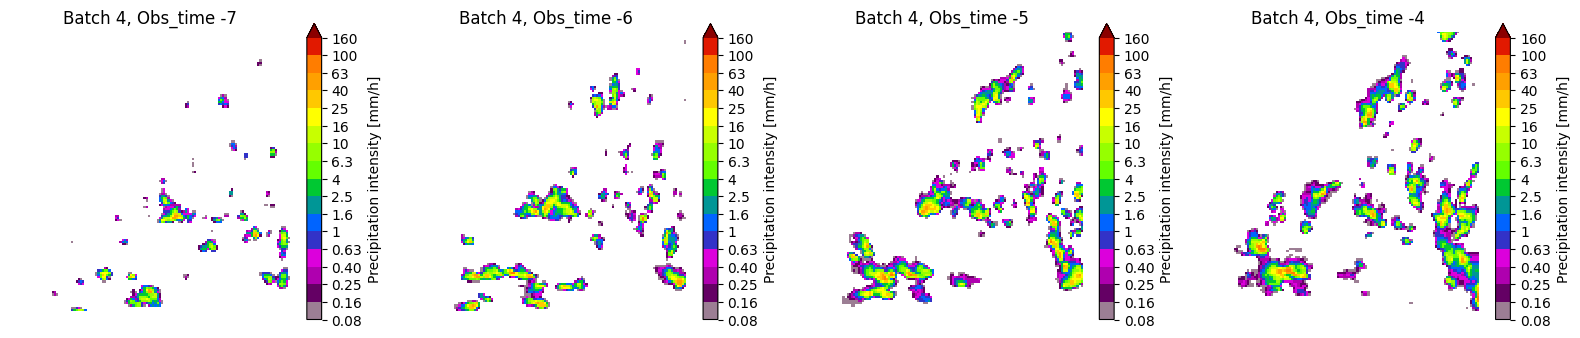

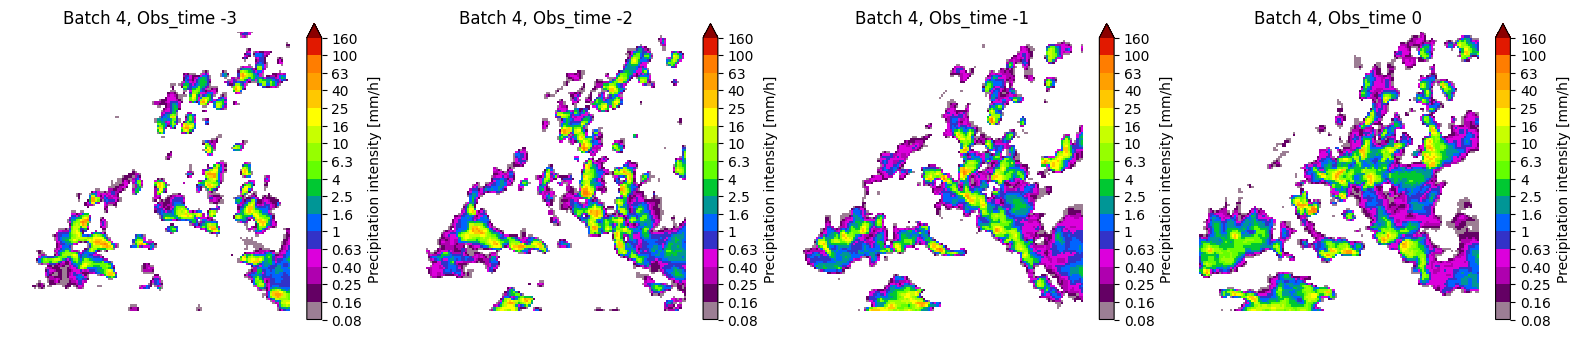

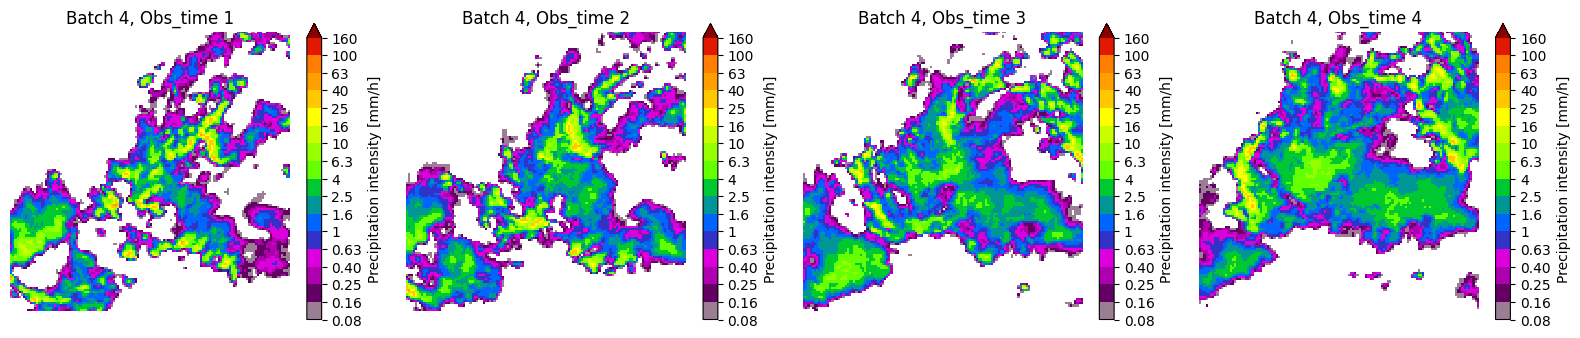

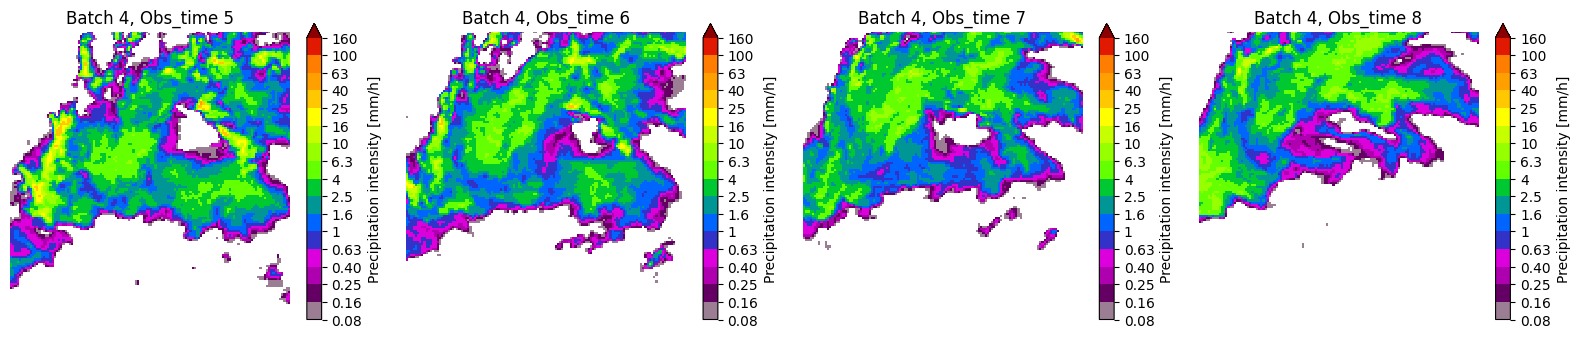

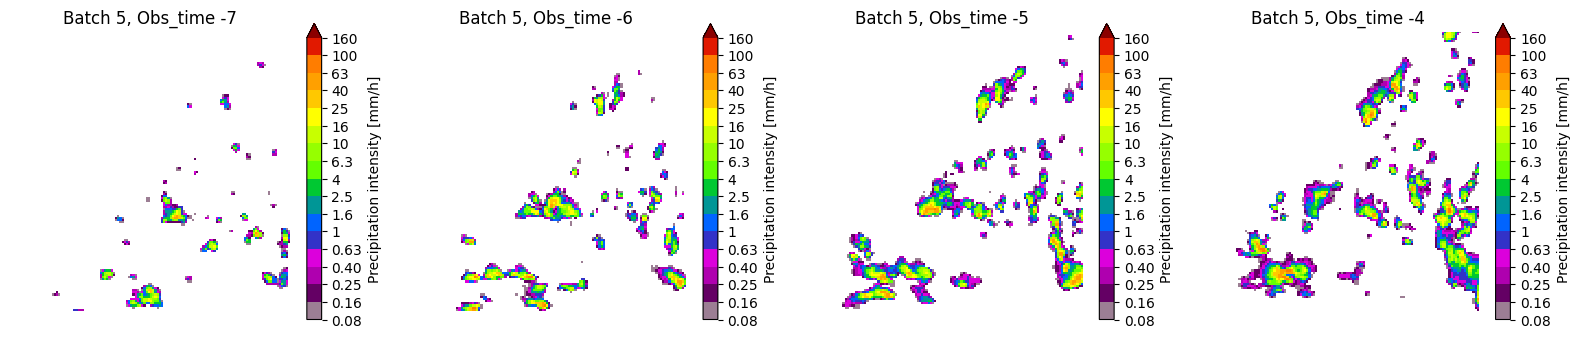

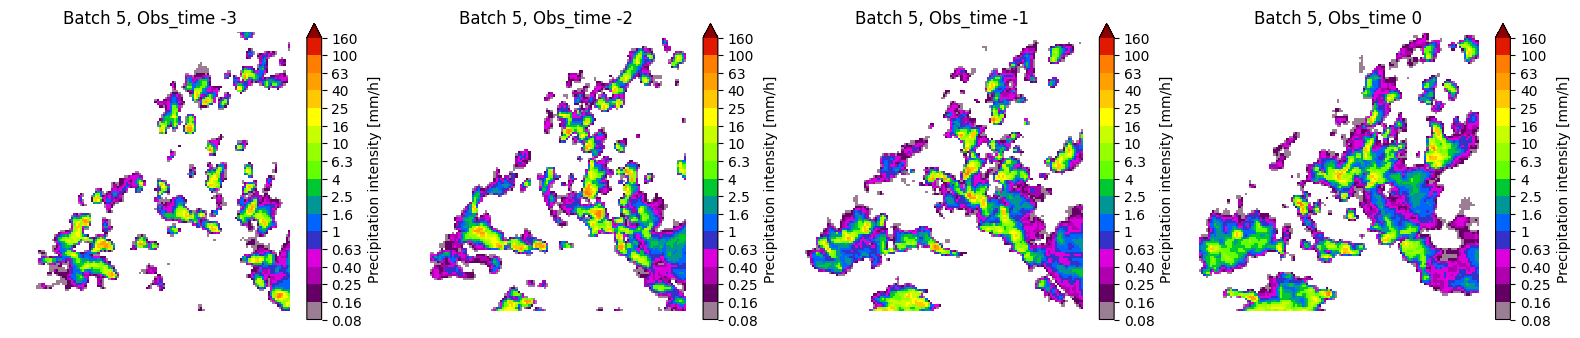

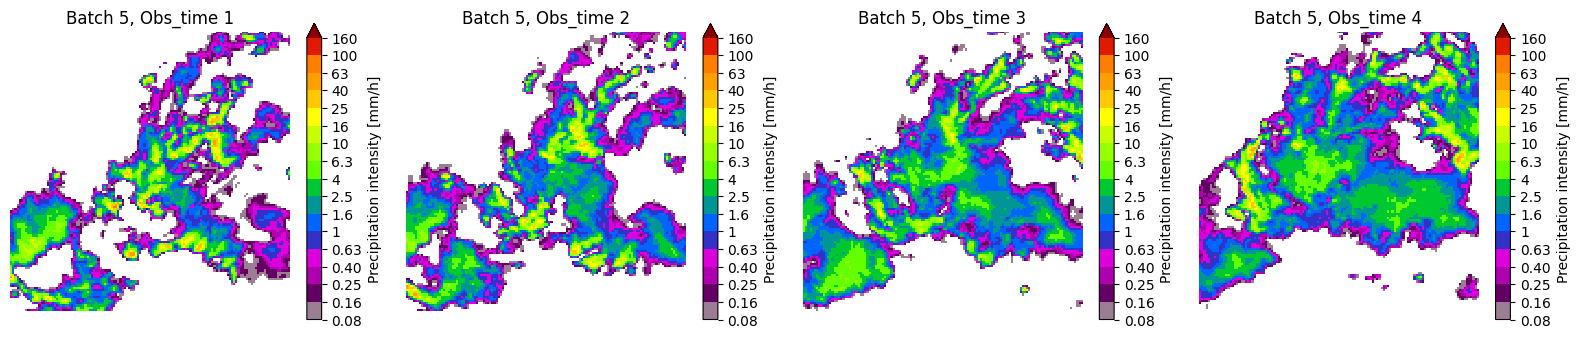

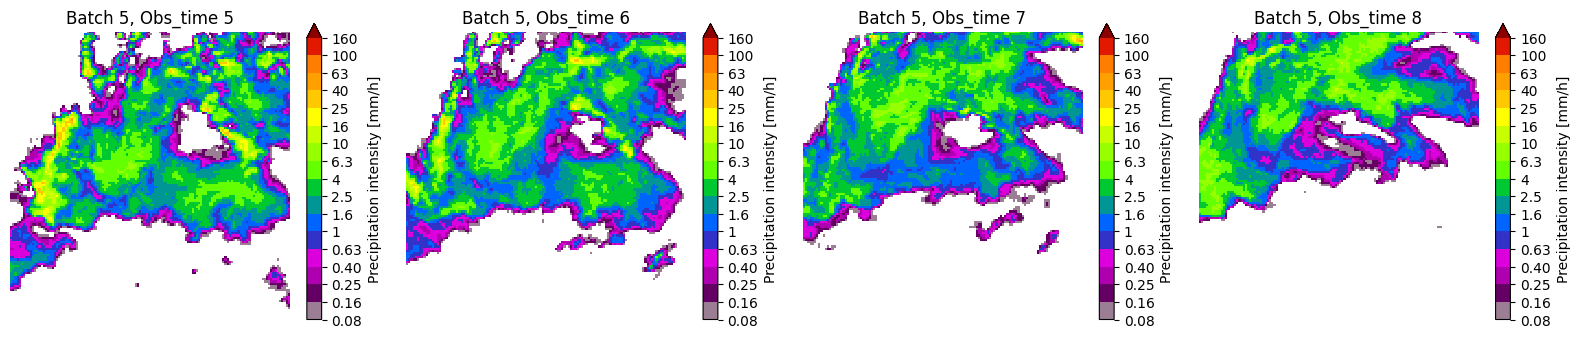

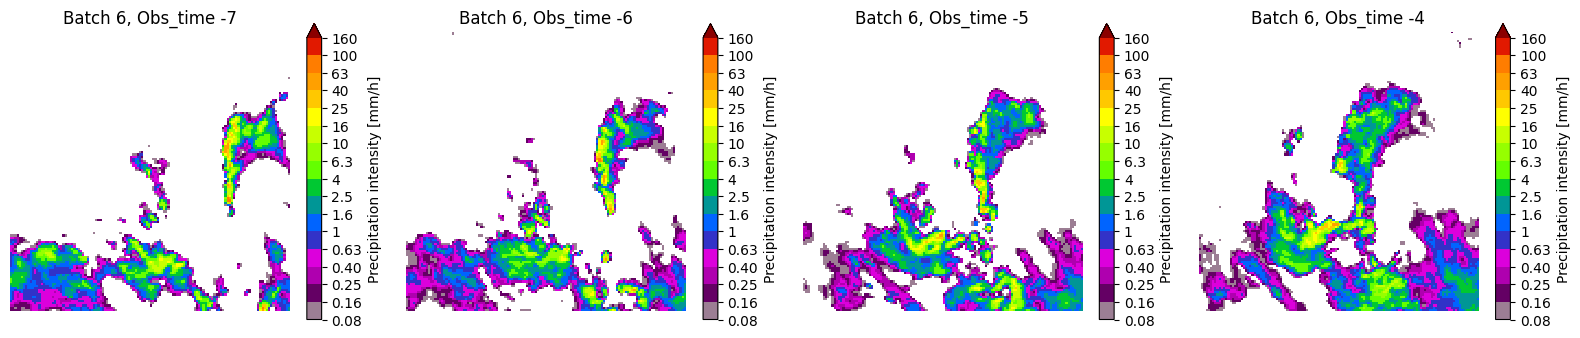

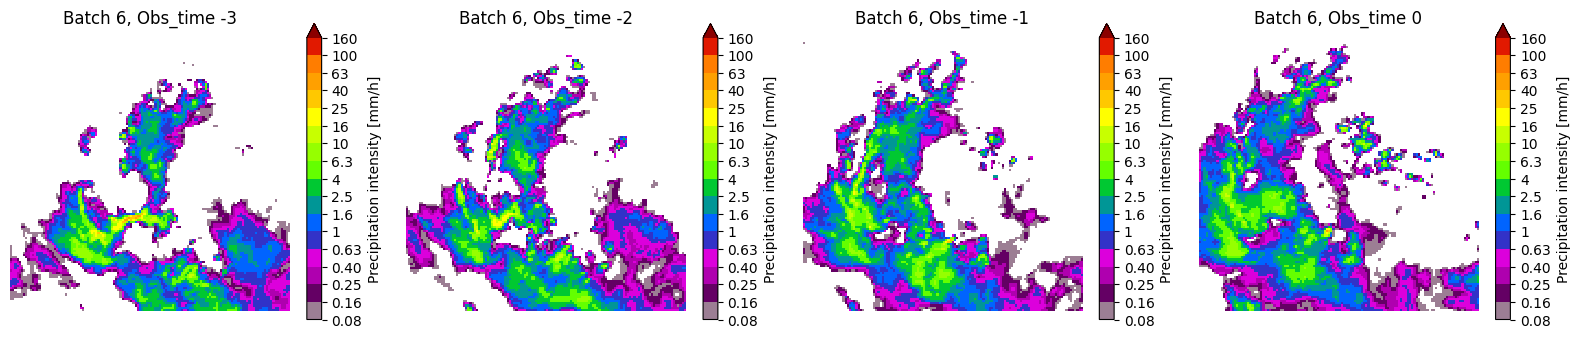

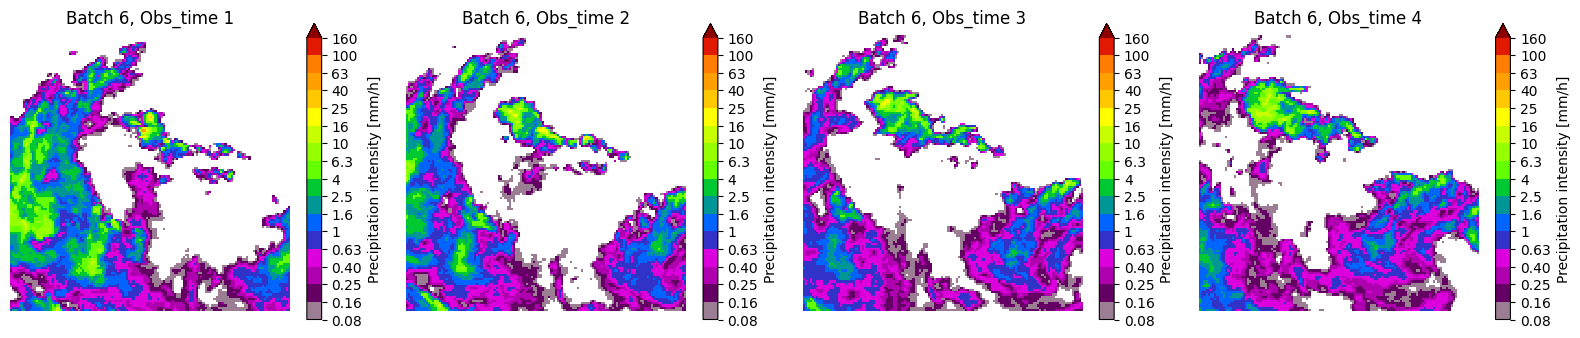

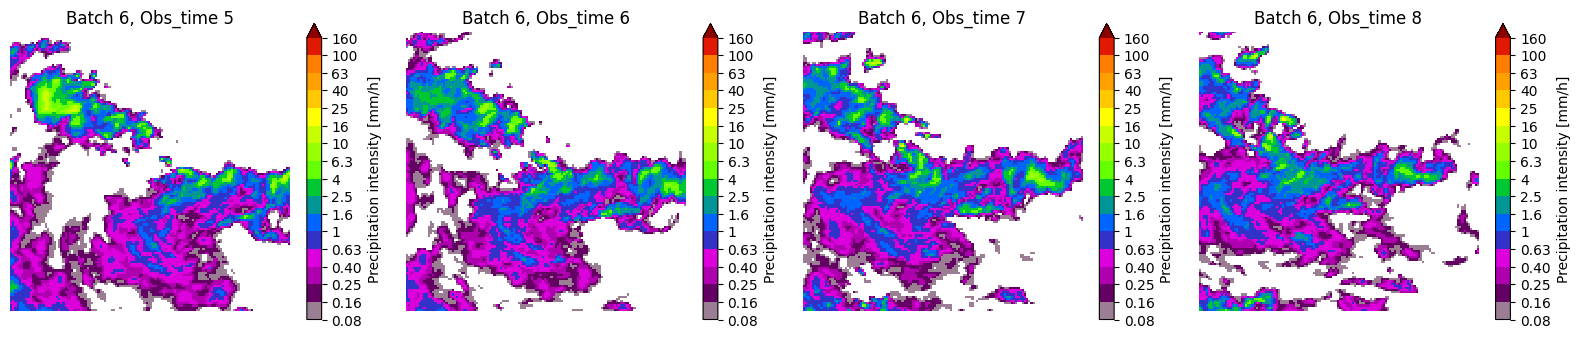

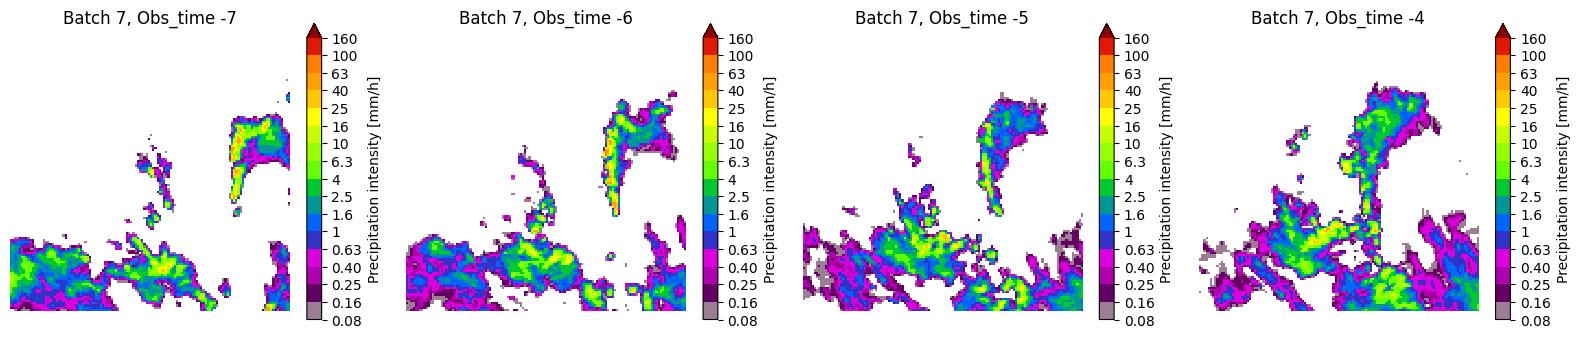

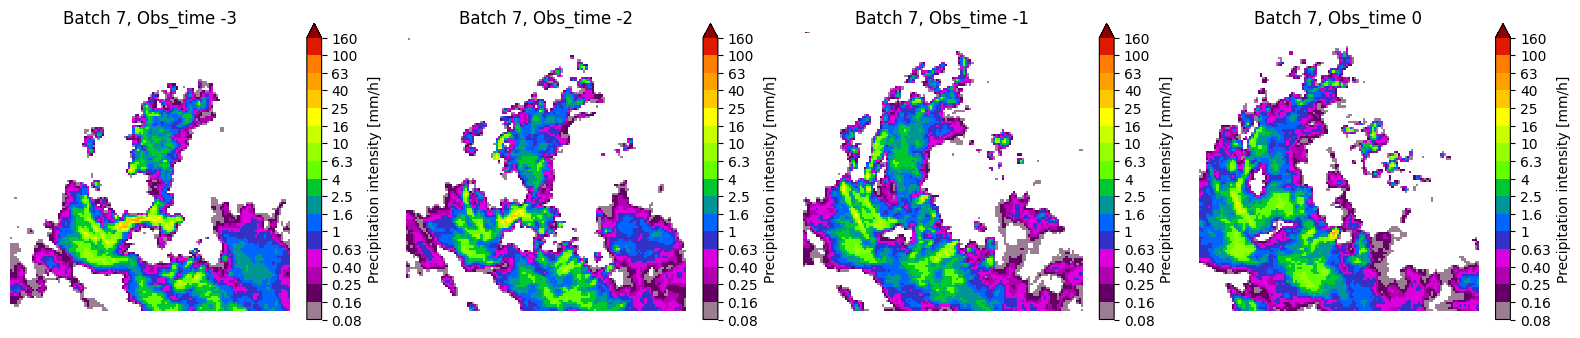

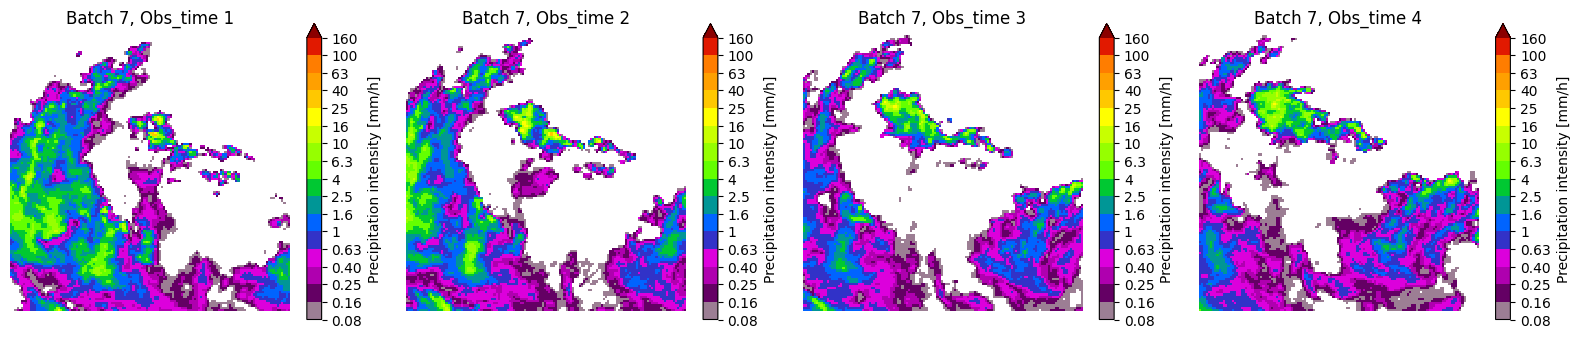

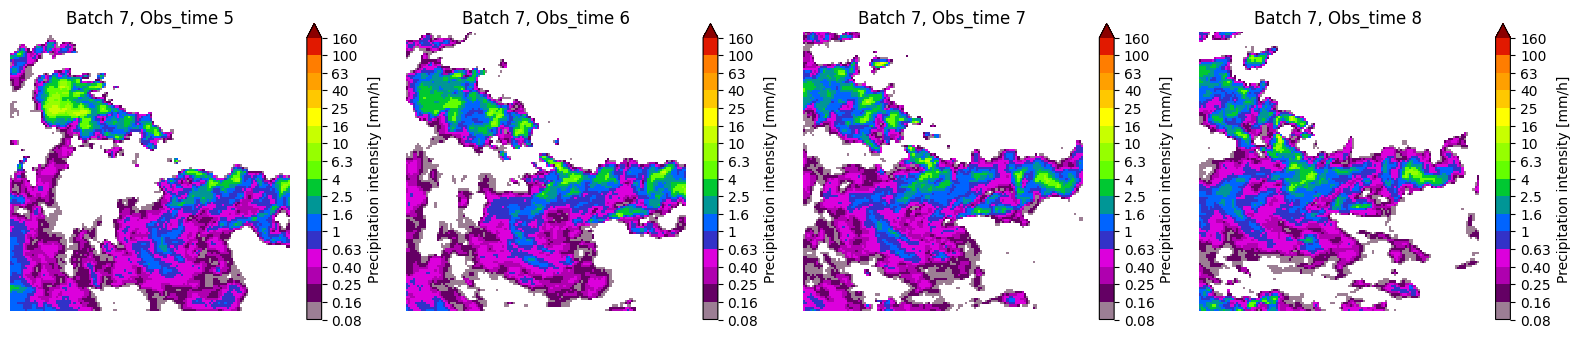

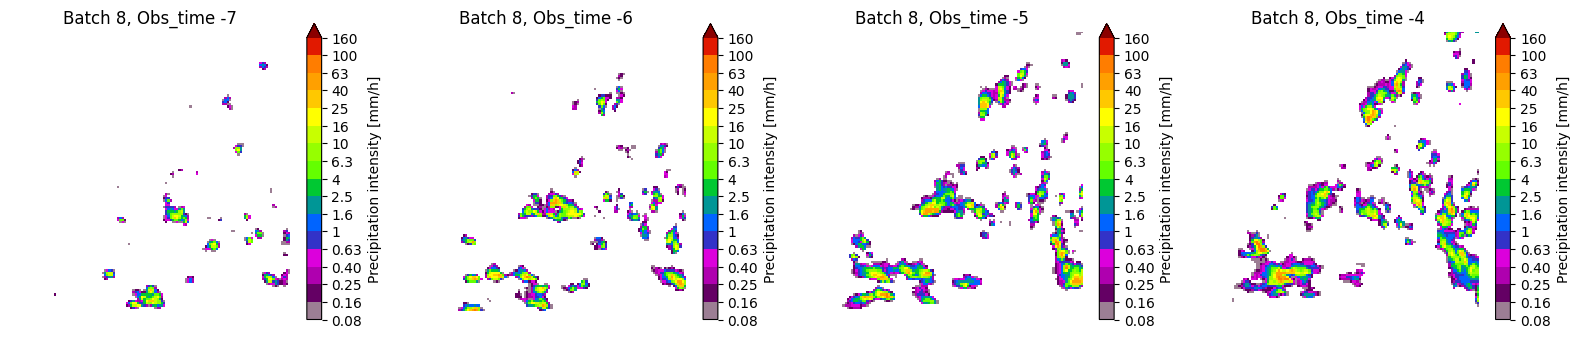

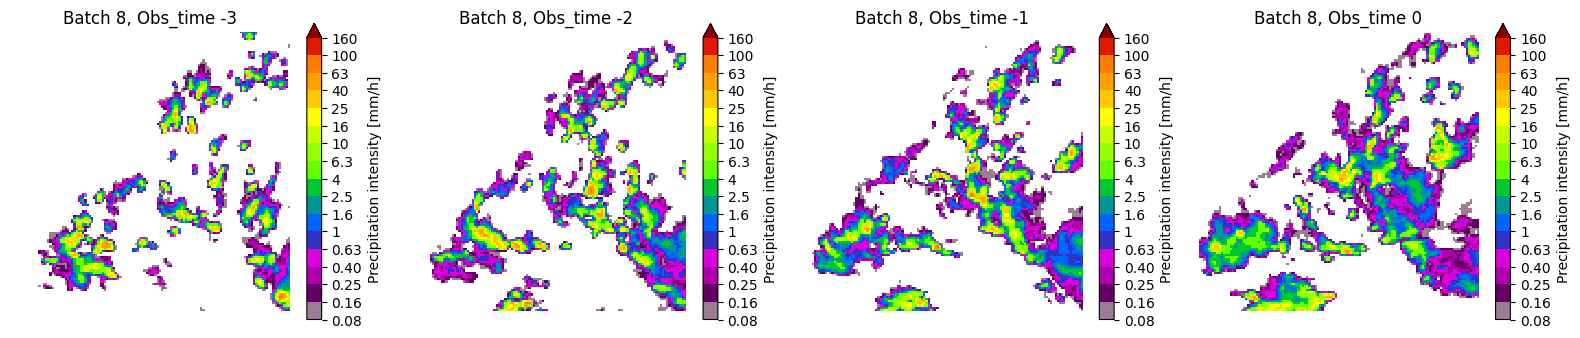

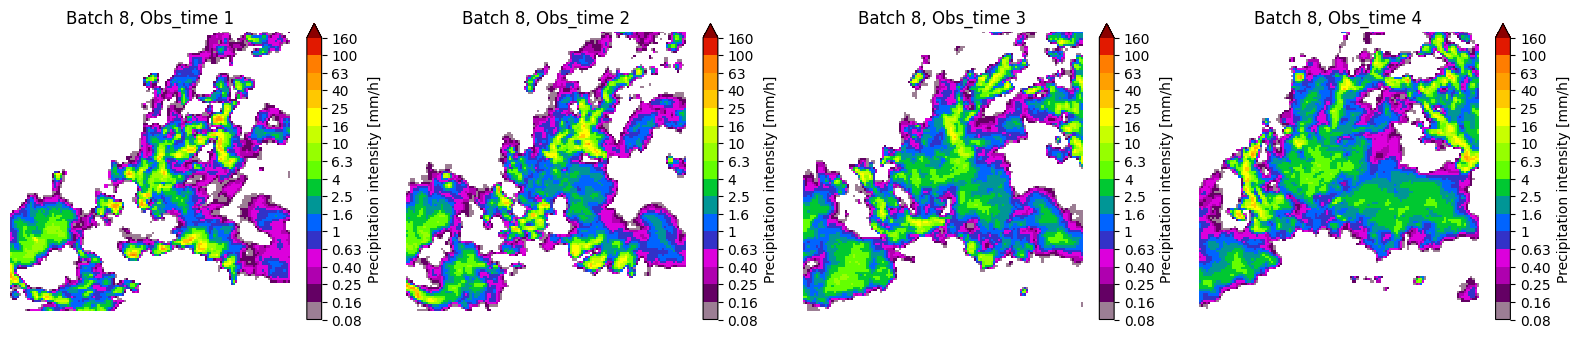

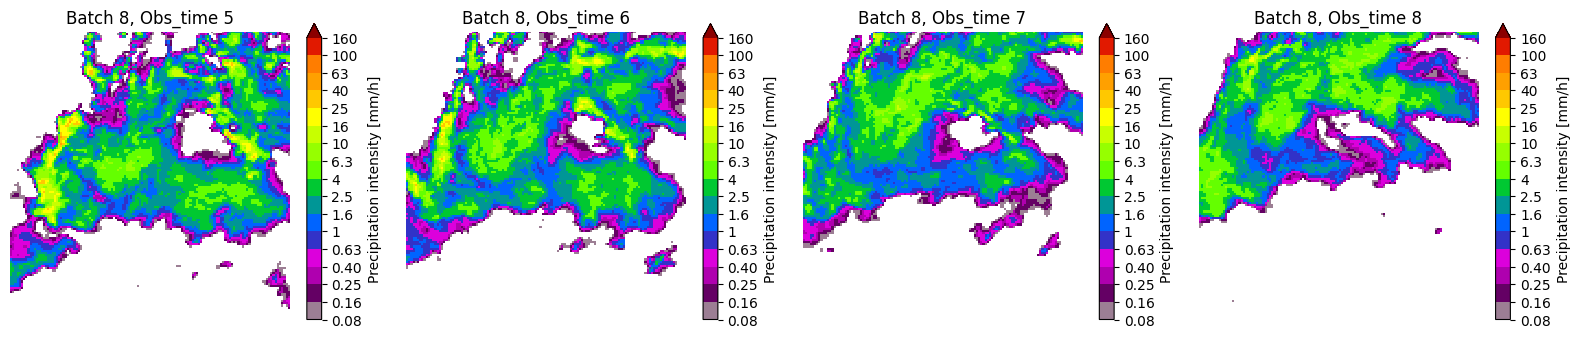

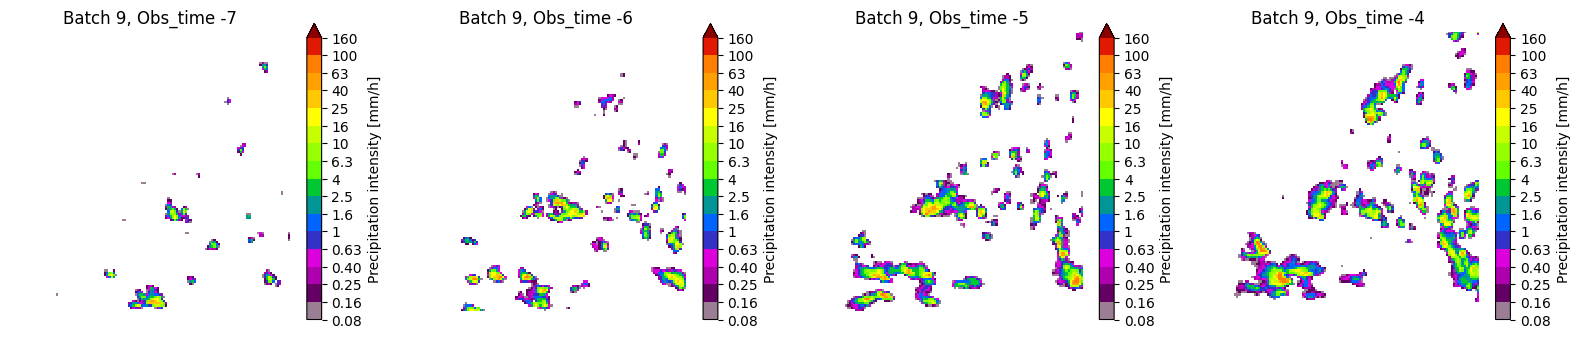

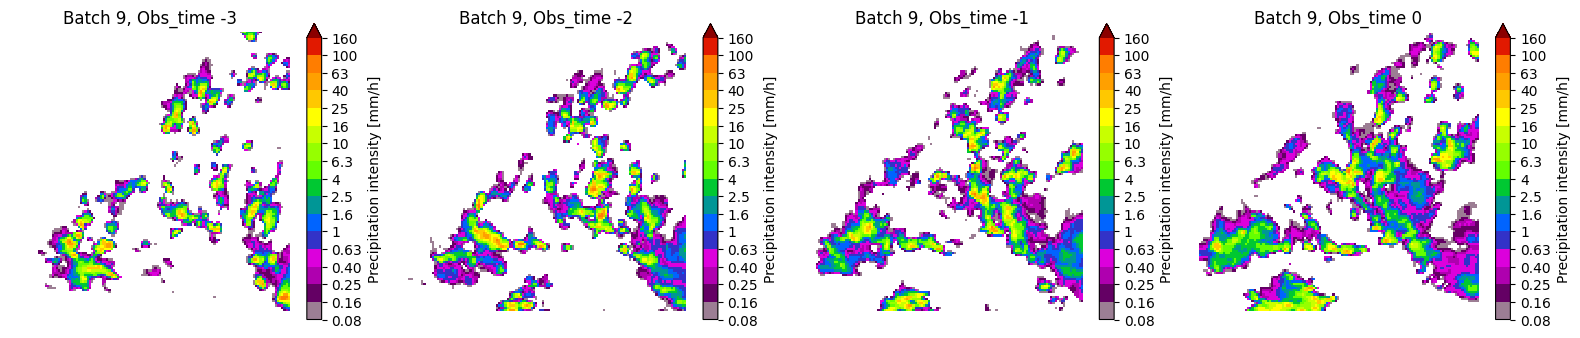

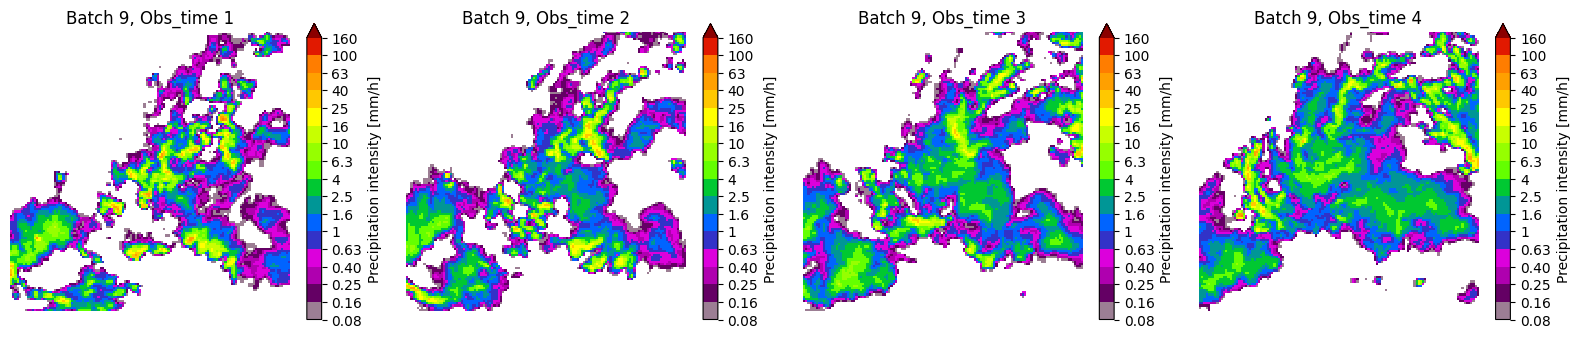

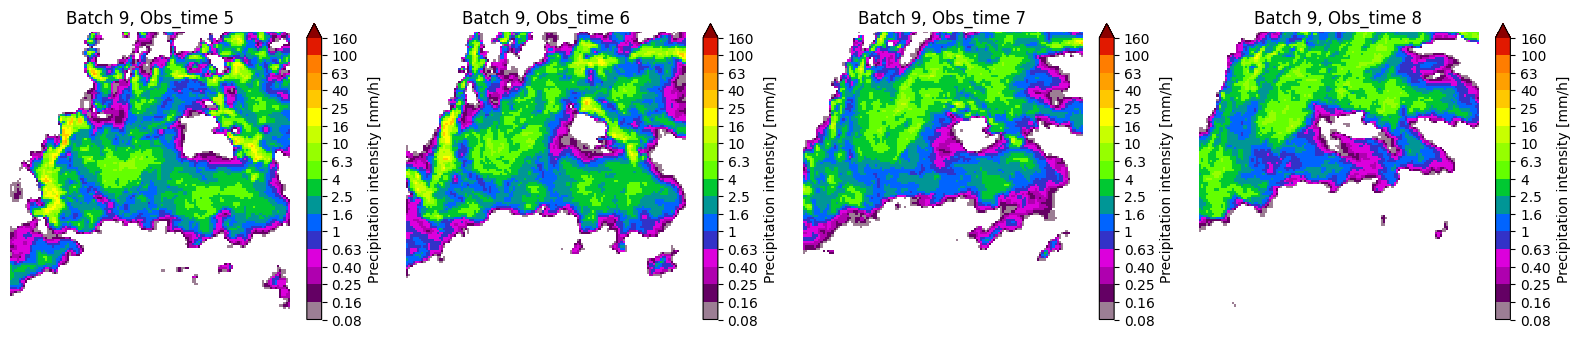

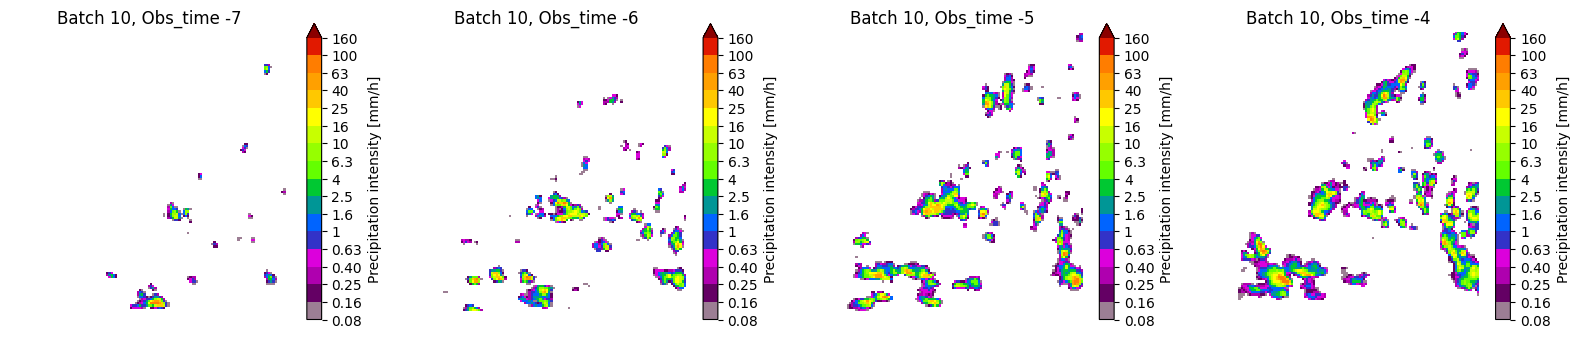

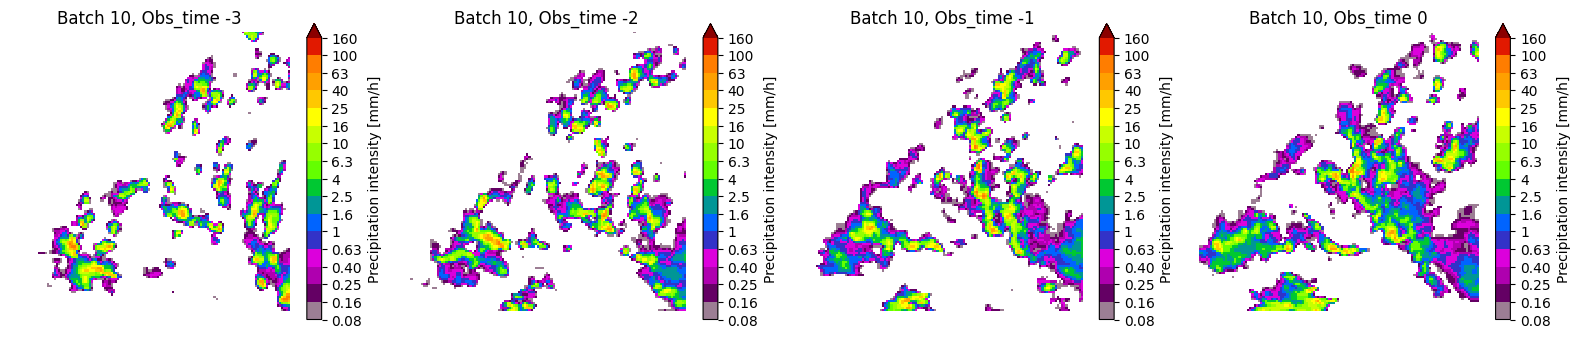

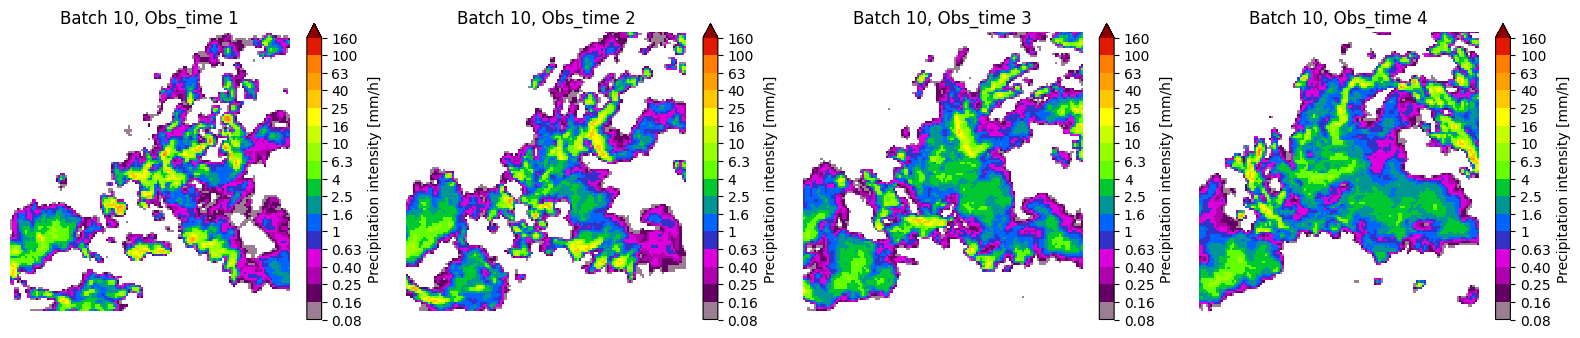

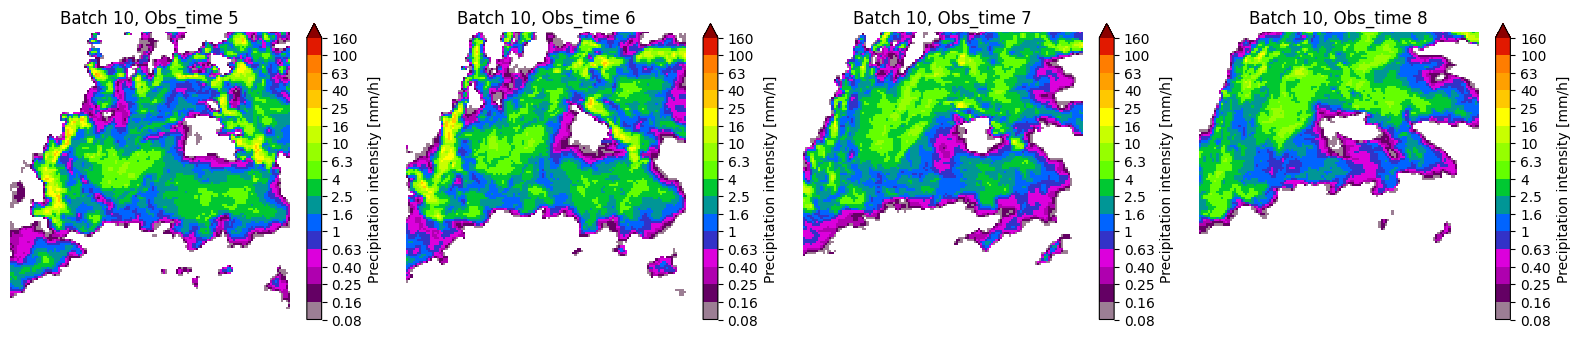

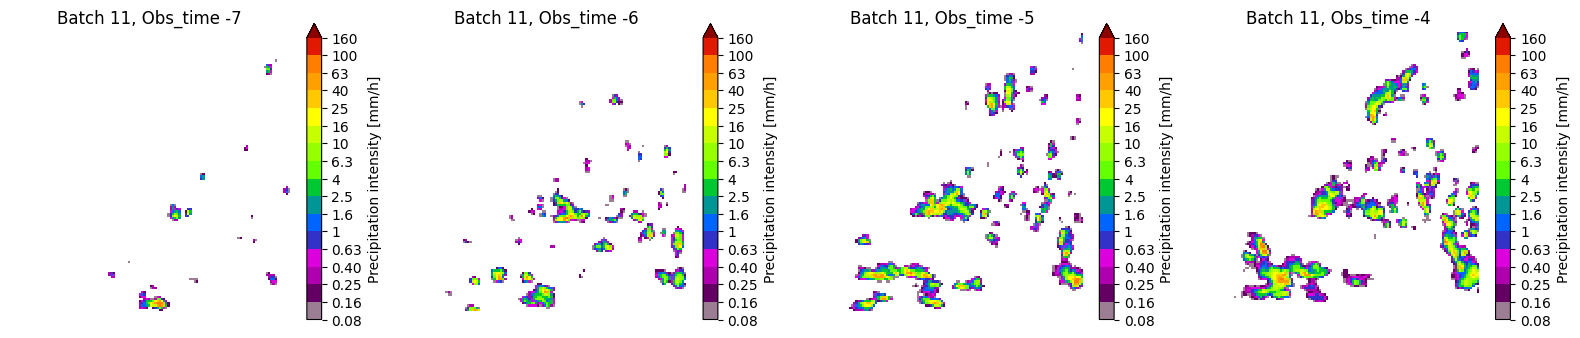

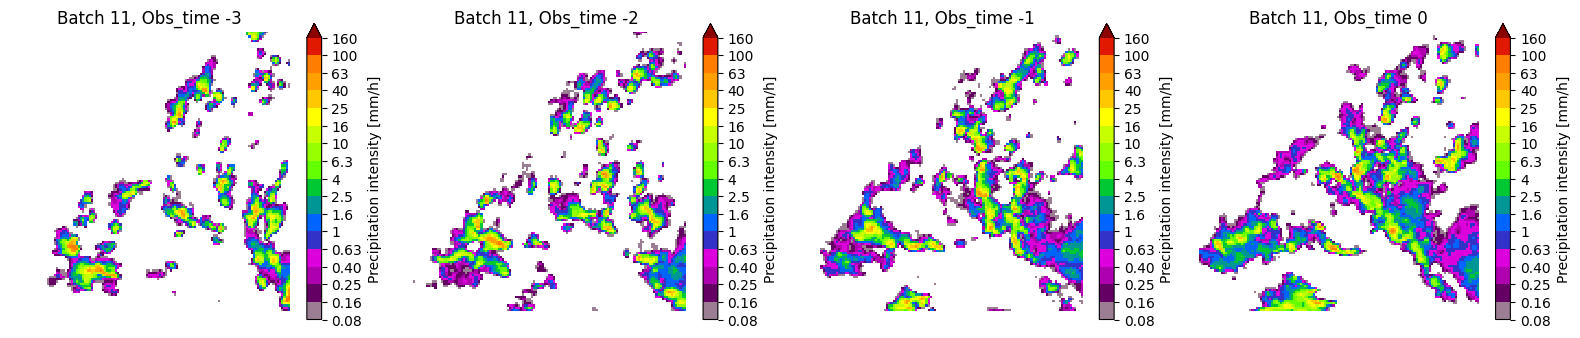

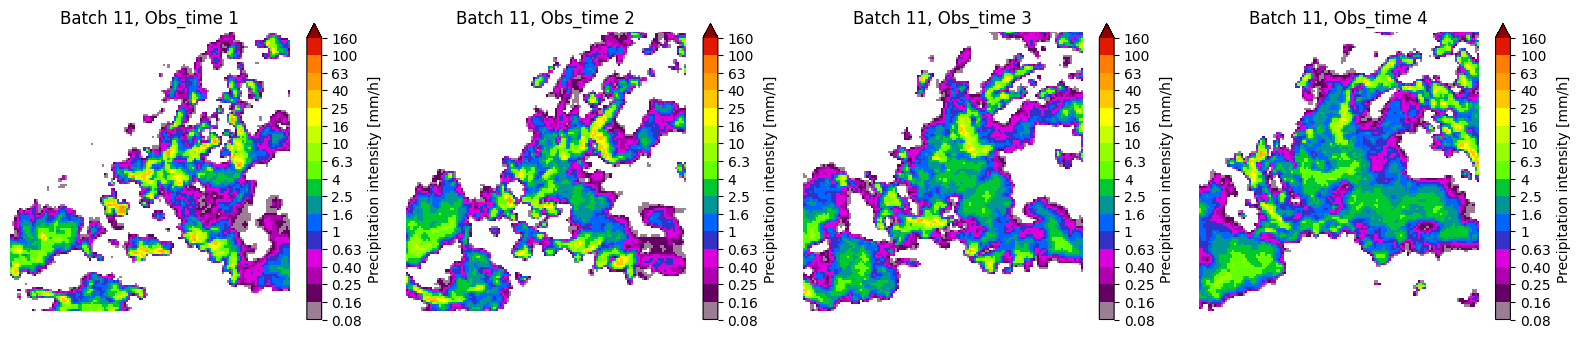

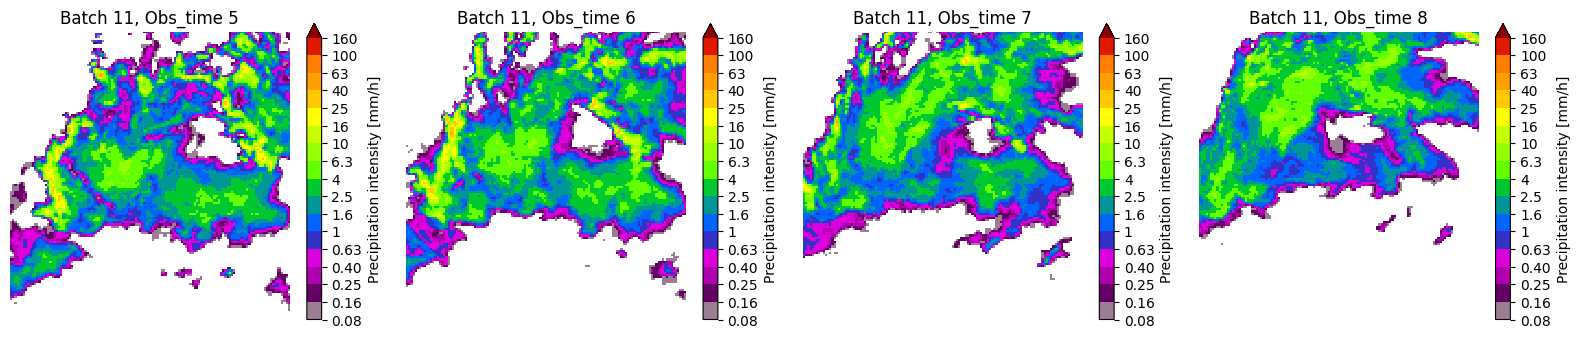

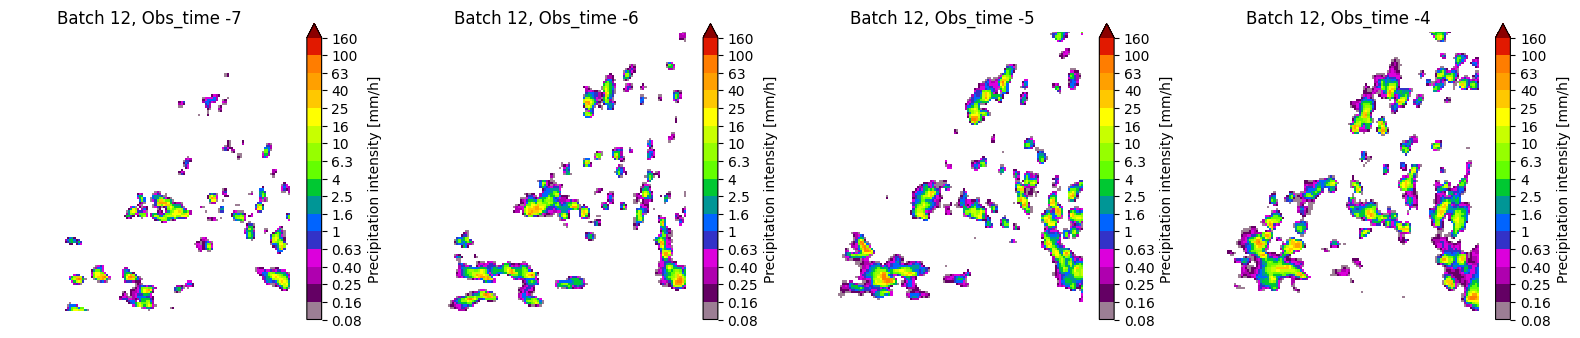

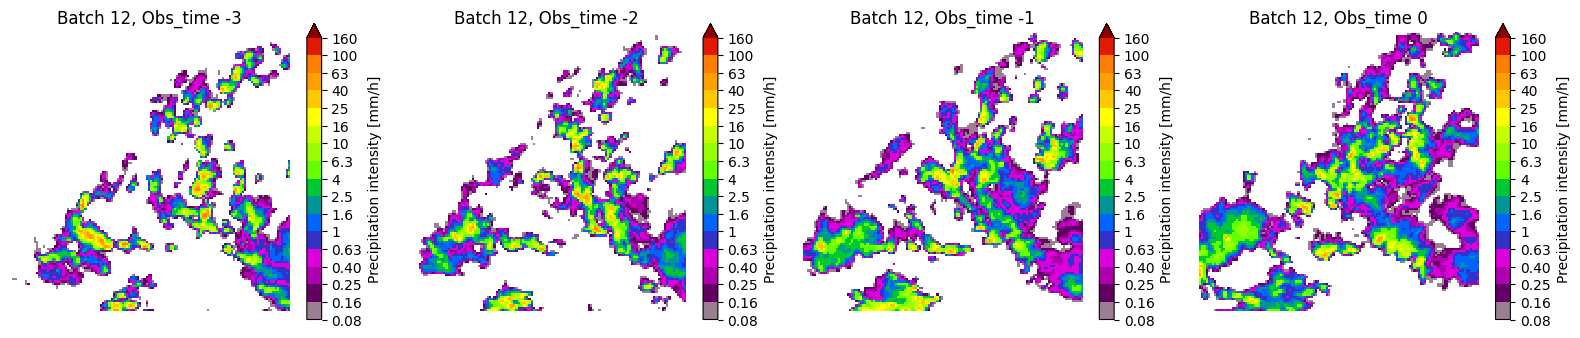

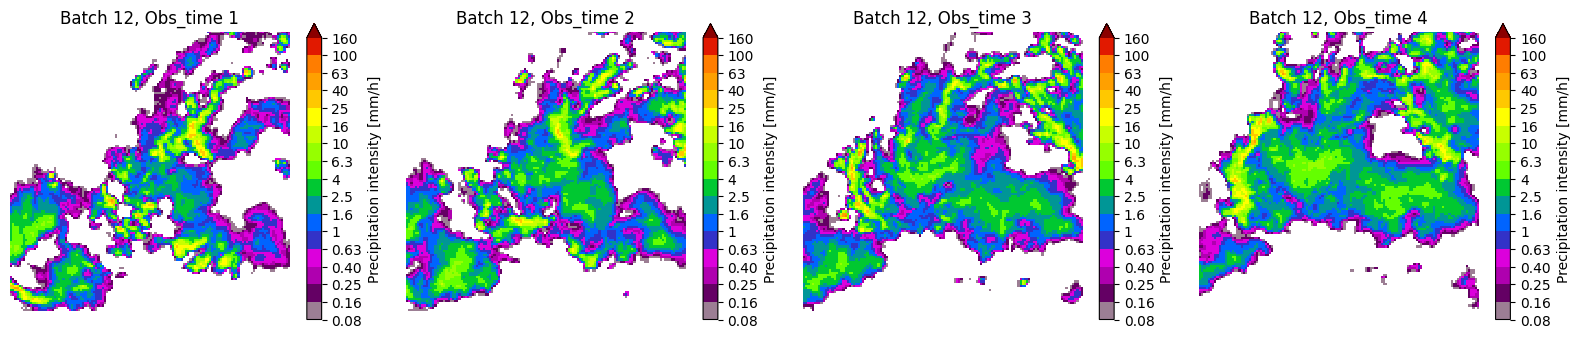

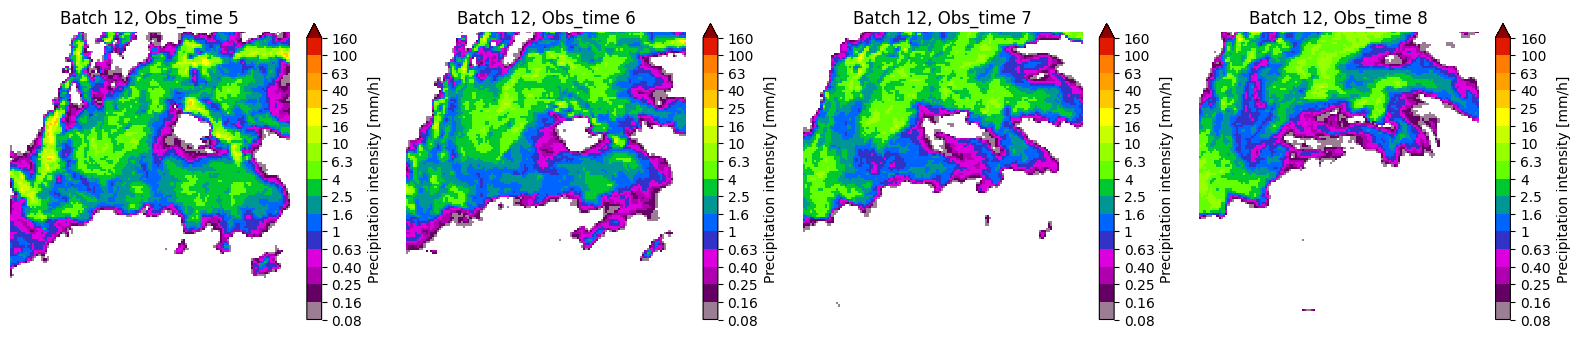

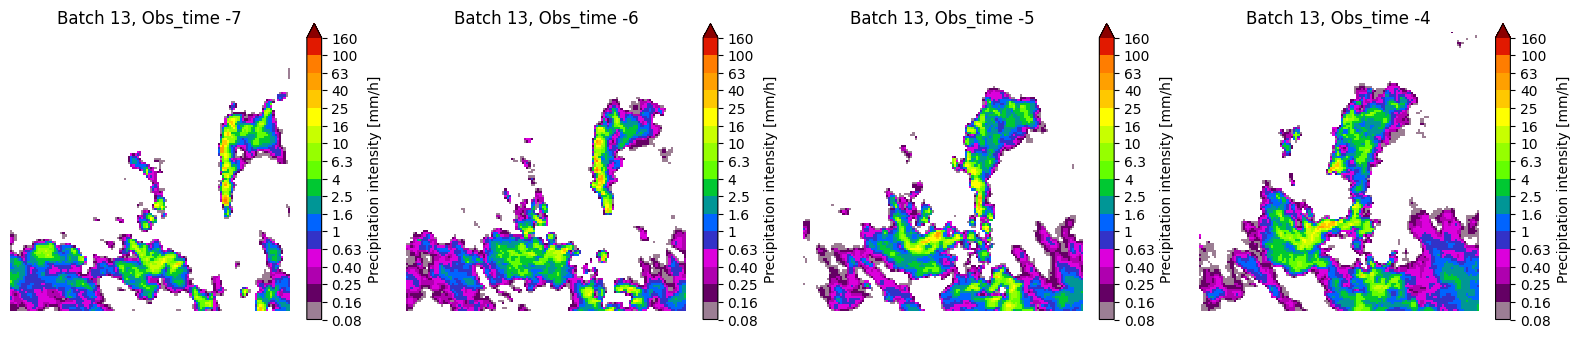

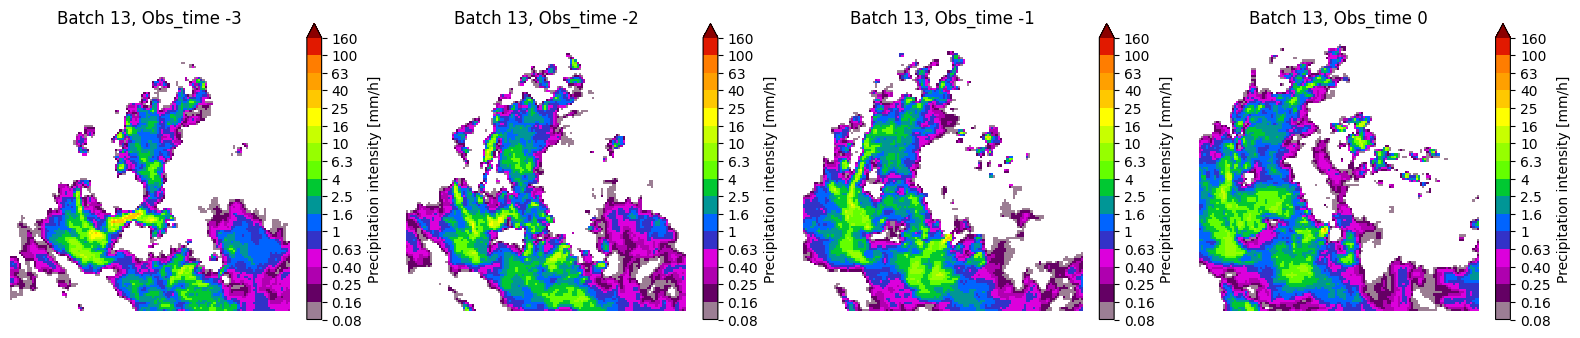

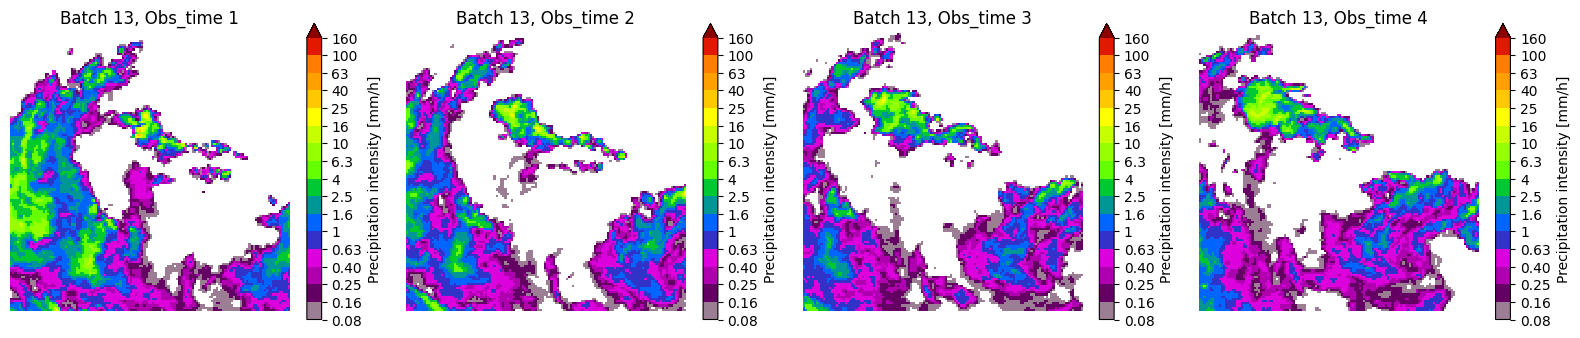

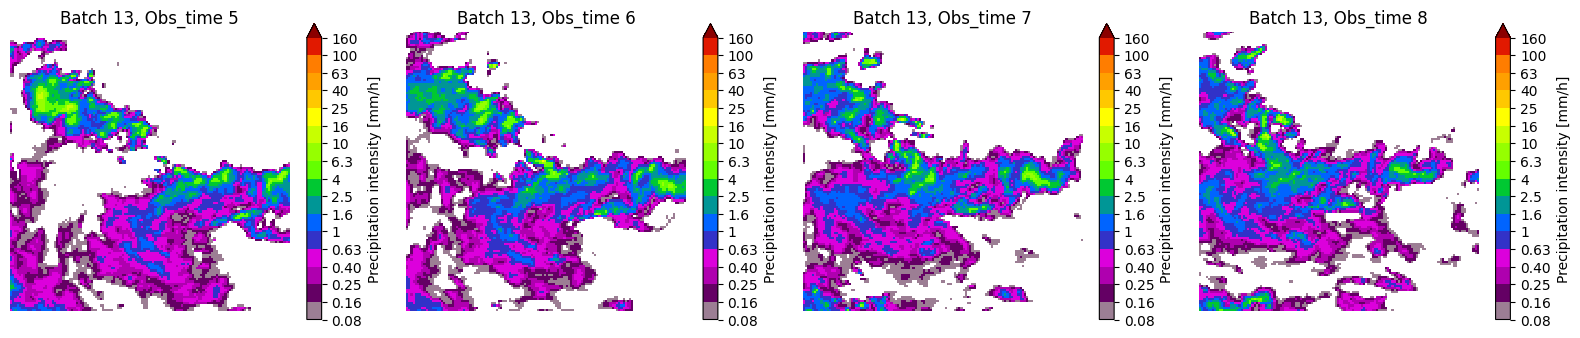

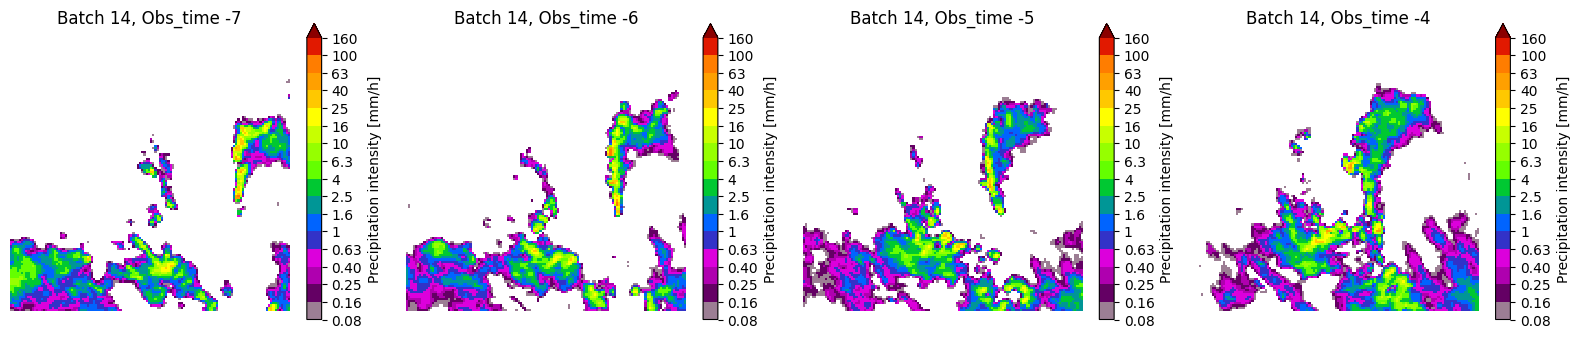

KeyboardInterrupt: 

In [90]:
# Select the channel (e.g., first channel) to plot
channel_idx = 0
obs_idx=0

# Define the number of columns for subplots (4 observations in one row)
num_columns = 4

# Calculate the number of rows based on the number of batches
num_rows = 4

# Iterate through the batch dimension and observation dimension, then plot each observation
for batch_idx in range(observations.size(1)):
    
    obs_idx=0
    for i in range(num_rows):
        # Create a figure with 1 row and 4 columns
        plt.figure(figsize=(16, 4))
        for j in range(num_columns):
            # Calculate the subplot index within the 1x4 grid
            subplot_idx = j + 1  # Add 1 to start with index 1

            # Extract a single observation and reshape
            observation = observations[obs_idx, batch_idx, :, :].numpy() * 40
            # Plot the observation in the corresponding subplot
            plt.subplot(1, num_columns, subplot_idx)
            plot_precip_field(observation, geodata=None, title=f"Batch {batch_idx+1}, Obs_time {obs_idx-7}")
            plt.axis('off')
            obs_idx+=1

        plt.tight_layout()
        plt.show()

In [89]:
# Select the channel (e.g., first channel) to plot
channel_idx = 0
obs_idx=0

# Define the number of columns for subplots (4 observations in one row)
num_columns = 4

# Calculate the number of rows based on the number of batches
num_rows = 4

# Iterate through the batch dimension and observation dimension, then plot each observation
for batch_idx in range(observations.size(0)):
    
    obs_idx=0
    for i in range(num_rows):
        # Create a figure with 1 row and 4 columns
        plt.figure(figsize=(16, 4))
        for j in range(num_columns):
            # Calculate the subplot index within the 1x4 grid
            subplot_idx = j + 1  # Add 1 to start with index 1

            # Extract a single observation and reshape
            observation = observations[batch_idx, obs_idx, :, :, channel_idx].numpy() * 40
            # Plot the observation in the corresponding subplot
            plt.subplot(1, num_columns, subplot_idx)
            plot_precip_field(observation, geodata=None, title=f"Batch {batch_idx+1}, Obs_time {obs_idx-7}")
            plt.axis('off')
            obs_idx+=1

        plt.tight_layout()
        plt.show()

IndexError: too many indices for tensor of dimension 4

<Figure size 1600x400 with 0 Axes>